In [1]:
import os
import sys
import pickle
import json
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
import seaborn as sns
import numpy as np
import pandas as pd
from scipy.stats import spearmanr

# Switch to parent path to import local module
parent_path = str(os.getcwd()).split('notebooks')[0] # zeosyn_gen
os.chdir(parent_path)
print('Switched directory to:', os.getcwd())

from eval import get_metric_dataframes, get_prediction_and_ground_truths, eval_single_system
import data.utils as utils
sys.modules['utils'] = utils # Way to get around relative imports in utils for ZeoSynGen_dataset # https://stackoverflow.com/questions/2121874/python-pickling-after-changing-a-modules-directory

/home/synthesisproject/anaconda3/envs/zeo_diffusion_metrics_eq/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Switched directory to: /home/jupyter/Elton/Zeolites/zeosyn_gen


/home/synthesisproject/anaconda3/envs/zeo_diffusion_metrics_eq/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
with open(f'data/ZeoSynGen_dataset.pkl', 'rb') as f: # load dataset
    dataset = pickle.load(f)
syn_cols = dataset.ratio_names+dataset.cond_names

df_zeos = pd.read_csv('data/zeolite_descriptors_for_dendro.csv').drop(columns=['Unnamed: 0'])

In [3]:
# Small pore zeolites (8MR), Medium pore zeolites (10MR), Large pore zeolites (12MR), Extra large pore zeolites (>12MR)
s_pore = list(df_zeos[(df_zeos['ring_size_0'] >  0.) \
                    & (df_zeos['ring_size_0'] <= 8.) \
                    & (~df_zeos['ring_size_0'].isna()) \
                         ]['iza'])

m_pore = list(df_zeos[(df_zeos['ring_size_0'] > 8.) \
           & (df_zeos['ring_size_0'] <= 10.) \
           & (~df_zeos['ring_size_0'].isna()) \
                         ]['iza'])

l_pore = list(df_zeos[(df_zeos['ring_size_0'] > 10.) \
                    & (df_zeos['ring_size_0'] <= 12.) \
                    & (~df_zeos['ring_size_0'].isna()) \
                         ]['iza'])

xl_pore = list(df_zeos[(df_zeos['ring_size_0'] > 12.) \
                     & (~df_zeos['ring_size_0'].isna()) \
                         ]['iza'])
xl_pore.remove(np.nan)
len(s_pore), len(m_pore), len(l_pore), len(xl_pore)

(100, 61, 72, 22)

In [4]:
model_outputs = {}
for model_type, fname, split in [
                                # ('random', ['v0'], 'system'),
                                # ('amd', 'v0', 'system'),
                                # ('nn', ['v0'], 'system'),
                                # ('bnn', 'v0', 'system'),
                                # ('gmm', 'v0', 'system'),
                                # ('gan', 'v3', 'system'),
                                # ('nf', 'v0', 'system'),
                                # ('cvae', 'v10', 'system'),
                                ('diff', 'v3', 'system'),
                                ]:
    with open(f'runs/{model_type}/{split}/{fname}/configs.json') as f:
        configs = json.load(f)

    if model_type == 'diff':
        syn_pred, syn_pred_scaled, syn_true, syn_true_scaled, _ = get_prediction_and_ground_truths(_, configs, cond_scale=0.75)
    else:
        syn_pred, syn_pred_scaled, syn_true, syn_true_scaled, _ = get_prediction_and_ground_truths(_, configs)

    model_outputs[model_type] = {'syn_pred': syn_pred, 'syn_pred_scaled': syn_pred_scaled, 'syn_true': syn_true, 'syn_true_scaled': syn_true_scaled}

Getting model predictions and grouth truths...
SYSTEMS:
train+val: 1856 test: 464

n_datapoints:
train: 14749 val: 2107 test: 5168
Loading synthetic predictions from saved predictions...


In [5]:
zeos = list(syn_true['zeo'].unique())
zeos.remove('Dense/Amorphous')

pred = model_outputs['diff']['syn_pred']
true = model_outputs['diff']['syn_true']

temp_pred_means, temp_pred_stds, temp_preds = [], [], []
temp_true_means, temp_true_stds, temp_trues = [], [], []
zeo_list = []
fwds = []


for zeo in zeos:
    if zeo in l_pore:
        temp_pred = pred[pred['zeo']==zeo]
        temp_true = true[true['zeo']==zeo]

        pred_true_ratio = len(temp_pred) / len(temp_true)

        temp_true = temp_true[
                        # Non-fluoride synthesis
                        (temp_true['F/T'] == 0.)

                        # Non-AlPO
                        & ((temp_true['Al/P'] < 0.5) | (temp_true['Al/P'] > 1.5))

                        # Non-Ge
                        & (temp_true['Si/Ge'] > 90.)

                        # Non-B
                        & (temp_true['Si/B'] > 200.)

                        ]
        if len(temp_true) > 0:
            true_idxs = temp_true.index

            # Since predictions are stacked 50x that of true, we find the corresponding indices of predictions
            pred_idxs = np.concatenate(
                                            [np.arange(true_idx, true_idx+len(syn_true)*pred_true_ratio, len(syn_true)) for true_idx in true_idxs]
                                    ).reshape(-1)

            temp_pred = temp_pred.loc[pred_idxs]

            temp_pred = temp_pred['cryst_temp']
            temp_true = temp_true['cryst_temp']

            fwd = df_zeos[df_zeos['iza']==zeo]['framework_density'].item()
            
            temp_pred_means.append(temp_pred.median())
            temp_pred_stds.append(temp_pred.std())
            temp_preds.append(list(temp_pred))
            temp_true_means.append(temp_true.median())
            temp_true_stds.append(temp_true.std())
            temp_trues.append(list(temp_true))
            zeo_list.append(zeo)
            fwds.append(fwd)
            
        else:
            continue

df_temp_fwd = pd.DataFrame({'zeo': zeo_list, 'pred_mean': temp_pred_means, 'pred_std': temp_pred_stds, 'pred': temp_preds, 'true_mean': temp_true_means, 'true_std': temp_true_stds, 'true': temp_trues,'fwd': fwds})
df_temp_fwd = df_temp_fwd.sort_values('fwd')
df_temp_fwd = df_temp_fwd.dropna()
df_temp_fwd

,zeo,pred_mean,pred_std,pred,true_mean,true_std,true,fwd
2,FAU,110.0,26.187688,"[110.0, 110.0, 110.0, 100.0, 102.33481, 120.0,...",110.000000,18.789976,"[110.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100...",13.3
7,EMT,100.0,26.412795,"[100.0, 86.50864, 51.385384, 140.0, 100.0, 140...",81.629944,58.873627,"[123.25988006591797, 40.0]",13.3
14,BPH,150.0,32.227882,"[100.0, 100.0, 150.0, 175.0, 175.0, 175.0, 100...",150.000000,0.000000,"[150.0, 150.0]",14.6
3,ISV,150.0,9.685081,"[150.0, 150.0, 150.0, 150.0, 150.0, 175.0, 175...",165.000000,8.017838,"[165.0, 150.0, 150.0, 165.0, 165.0, 165.0, 170.0]",15.0
1,BEA,150.0,19.461963,"[150.0, 170.0, 175.0, 150.0, 150.0, 150.0, 150...",150.000000,20.350384,"[160.0, 150.0, 130.0, 175.0, 125.0, 125.0, 125...",15.3
16,OFF,150.0,15.275188,"[150.0, 170.0, 125.0, 150.0, 150.0, 170.0, 150...",125.000000,0.000000,"[125.0, 125.0, 125.0, 125.0, 125.0, 125.0, 125...",16.1
8,MAZ,120.0,47.977134,"[100.0, 70.2551, 140.0, 200.0, 75.01081, 139.4...",100.000000,27.173470,"[140.0, 140.0, 140.0, 140.0, 140.0, 140.0, 100...",16.7
10,EON,170.0,23.522758,"[200.0, 120.0, 130.0, 120.0, 140.0, 100.0, 150...",140.000000,14.142136,"[130.0, 150.0]",16.8
6,AFI,170.0,12.471808,"[180.0, 190.0, 190.11543, 188.13838, 200.0, 19...",170.000000,10.055402,"[170.0, 170.0, 170.0, 150.0, 150.0, 175.0, 175...",16.9
4,MOR,160.0,8.374008,"[160.0, 160.0, 160.0, 160.0, 160.0, 160.0, 160...",160.000000,10.136308,"[160.0, 160.0, 160.0, 135.0, 170.0, 170.0, 170...",17.0


In [6]:
# zeos_to_drop = ['EMT', 'BPH', 'OFF', 'STO'] # drop these as their cryst temp are not a distribution
zeos_to_drop = ['BPH', 'MAZ', 'EON', 'AFI', 'MOR'] # drop these as their cryst temp are not a distribution
df_temp_fwd = df_temp_fwd[~df_temp_fwd['zeo'].isin(zeos_to_drop)]

In [7]:
_temps = []
_zeos = []
for zeo in df_temp_fwd['zeo']:
    ts = df_temp_fwd[df_temp_fwd['zeo']==zeo]['pred'].item()
    _temps += ts
    _zeos += [zeo]*len(ts)

df = pd.DataFrame({'zeo': _zeos, 'temp': _temps})
df

,zeo,temp
0,FAU,110.00000
1,FAU,110.00000
2,FAU,110.00000
3,FAU,100.00000
4,FAU,102.33481
...,...,...
10995,STO,160.00000
10996,STO,160.00000
10997,STO,160.00000
10998,STO,160.00000


<Figure size 4500x2400 with 0 Axes>

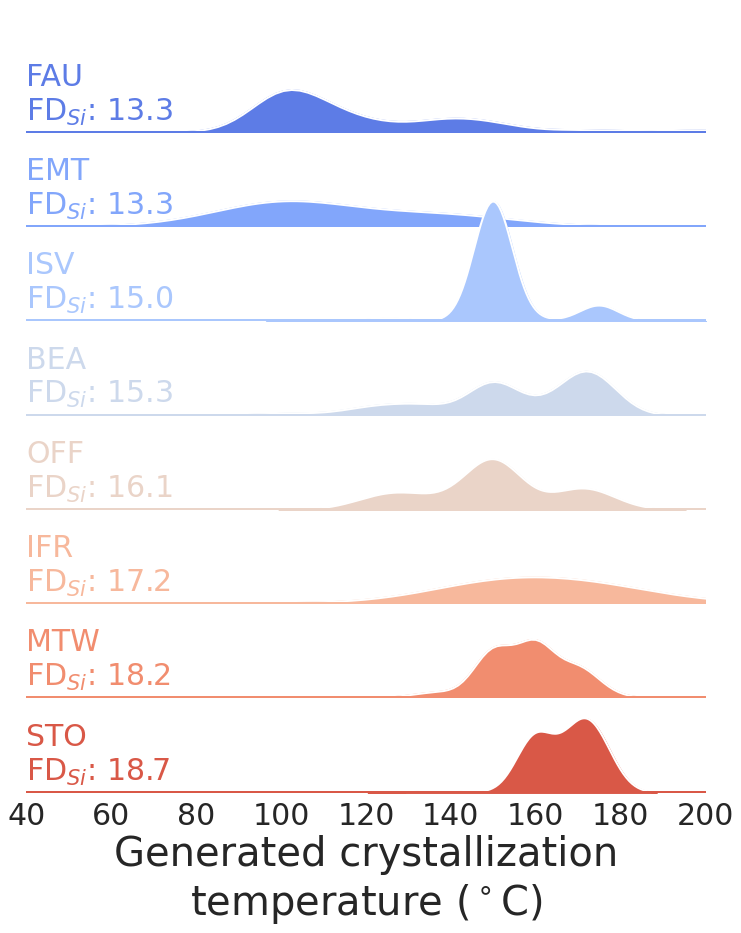

In [25]:
plt.figure(figsize=(15, 8), dpi=300)
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

# Initialize the FacetGrid object
pal = sns.mpl_palette(name='coolwarm', n_colors=len(df['zeo'].unique()))
g = sns.FacetGrid(df, row="zeo", hue="zeo", aspect=7, height=1.5, palette=pal) # change aspect to adjust figureshape

# Draw the densities in a few steps
g.map(sns.kdeplot, "temp",
      bw_adjust=1.5, clip_on=True,
      fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot, "temp", 
      bw_adjust=1.5, clip_on=True, color="white", lw=2)

# passing color=None to refline() uses the hue mapping
g.refline(y=0, linewidth=4, linestyle="-", color=None, clip_on=True)


# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    fwd = str(df_temp_fwd[df_temp_fwd['zeo']==label]['fwd'].item())
    ax.text(0, .30, label+'\nFD$_{Si}$: '+fwd, color=color,
            ha="left", va="center", transform=ax.transAxes, fontsize=30)


g.map(label, "temp")

# Set the subplots to overlap
g.figure.subplots_adjust(hspace=-.25)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)

g.set(xlim=(40, 200))

plt.xticks(fontsize=30)
plt.xlabel('Generated crystallization\ntemperature ($^\circ$C)', fontsize=40)
# plt.savefig('figs/temp_vs_fwd.png', dpi=300)
plt.show()

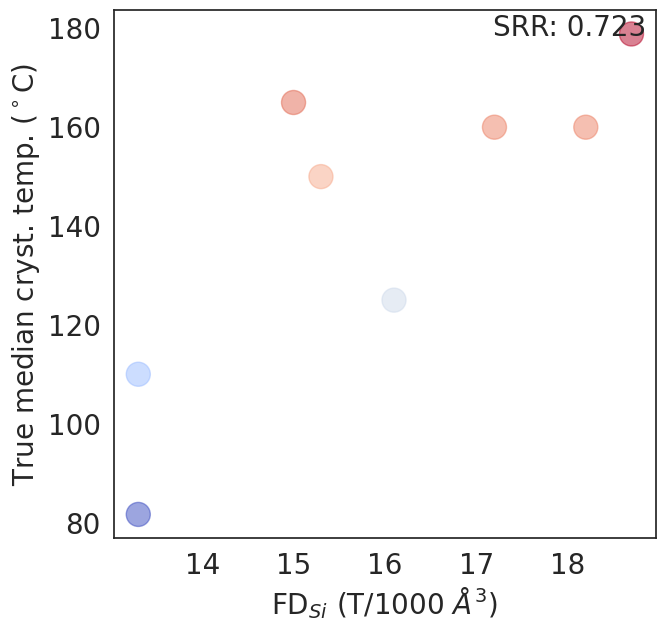

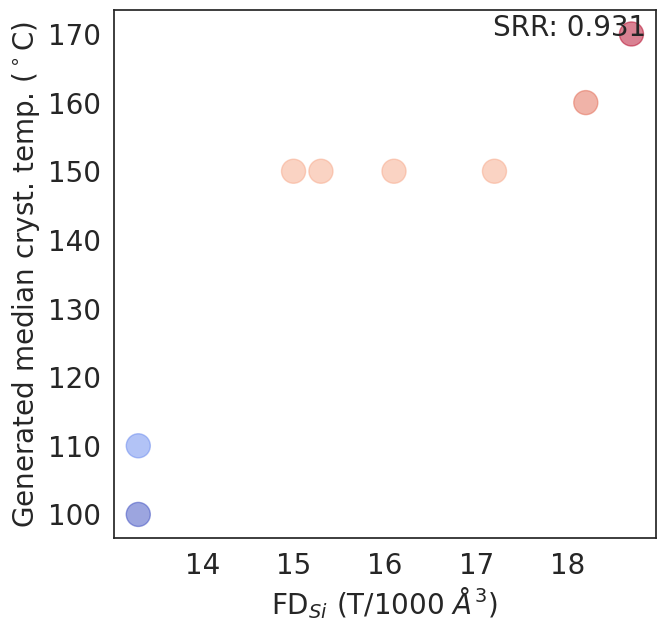

In [9]:
xlim = [14, 19]
ylim = [1, 45]
for i in ['true', 'pred']:
    fig, ax = plt.subplots(figsize=(7,7), dpi=100)
    plt.scatter(df_temp_fwd['fwd'], df_temp_fwd[f'{i}_mean'], marker='o', s=300, alpha = 0.5, c=df_temp_fwd[f'{i}_mean'], cmap='coolwarm')
    # plt.errorbar(df_temp_fwd['fwd'], df_temp_fwd[f'{i}_mean'], yerr=df_temp_fwd[f'{i}_std'], marker='o', alpha = 0.5, linestyle='None')
    plt.xlabel('FD$_{Si}$ (T/1000 $\AA^3$)', fontsize=20)
    if i == 'true':
        plt.ylabel('True median cryst. temp. ($^\circ$C)', fontsize=20)
    elif i == 'pred':
        plt.ylabel('Generated median cryst. temp. ($^\circ$C)', fontsize=20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    srr = round(spearmanr(df_temp_fwd['fwd'], df_temp_fwd[f'{i}_mean'])[0], 3)
    plt.text(0.7, 0.95, f'SRR: {srr}', fontsize=20, transform=ax.transAxes)
    xs, ys = [1e5], [1e5]
    dist_threshold = 1
    for zeo, x, y in zip(df_temp_fwd['zeo'], df_temp_fwd['fwd'], df_temp_fwd[f'{i}_mean']):
        if xlim[0] < x < xlim[1] and ylim[0] < y < ylim[1]:
            dists = [np.sqrt((x-xs[-1])**2 + (y-ys[-1])**2) for xs, ys in zip([xs], [ys])]
            min_dist = min(dists)   
            if min_dist < dist_threshold:
                x += 0.25
            
            xs.append(x), ys.append(y)
            plt.text(x, y, zeo, fontsize=15)

    # plt.xlim(*xlim)
    # plt.ylim(*ylim)

    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    ax.tick_params(which='minor', length=3)
    if i == 'pred':
        plt.savefig(f'figs/temp_vs_fwd.pdf', bbox_inches='tight')
    plt.show()